Part 2 - Data Mining Techniques

Team Members

- Gerasimos Bekos
- Dimitrios Stefanos - Porichis

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!pip install fasttext langid transformers
import pandas as pd

Mounted at /content/gdrive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 1.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.12.0-py3-none-any.whl (234 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4239660 sha256=47d3f95a87476dbe560280568f386b3cd19ea6cd5d8c8b2b6c6a6591f60e60e4
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941172 sha256=0624348c0b5e13819b861173a278ad33c98b51a56e4a132fea5e3eca426172fd
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built fasttext langid


## Data Cleaning

Separation of reviews based on year, and selection of a random sample of 10,000 for each year.

From these, we keep only those written in English.

In [ ]:
import pandas as pd

import langid

april19 = pd.read_csv('/content/gdrive/MyDrive/data/2019/april/reviews.csv')
febr19 = pd.read_csv('/content/gdrive/MyDrive/data/2019/febrouary/reviews.csv')
march19 = pd.read_csv('/content/gdrive/MyDrive/data/2019/march/reviews.csv')

all19 = pd.concat([febr19,march19,april19])
all19

march23 = pd.read_csv('/content/gdrive/MyDrive/data/2023/march/reviews.csv')
june23 = pd.read_csv('/content/gdrive/MyDrive/data/2023/june/reviews.csv')
sept23 = pd.read_csv('/content/gdrive/MyDrive/data/2023/september/reviews.csv')

all23 = pd.concat([march23,june23,sept23])

# Discard multiple instances of the same comment
all = pd.concat([all19, all23])
all = all.groupby('id').first()

# Deal with NA
all = all.dropna(subset=['comments'])

nan_counts = {}
for column in all.columns:
    nan_counts[column] = all[column].isna().sum()

# Print the NaN counts for each column
for column, count in nan_counts.items():
    print(f"NaN count in column '{column}': {count}")

# Create a year column in order to split the comments correctly
all['date'] = pd.to_datetime(all['date'])
all['year'] = all['date'].dt.year

# Get a 10000 entry sample of 2023
all23 = all[all['year'] == 2023]
all23 = all23.sample(n=10000, random_state=52)

# Same for 2019
all19 = all[all['year'] == 2019]
all19 = all19.sample(n=10000, random_state=52)

print(all19.shape)
print(all23.shape)

# Keep only english comments

def is_english(comment):
    lang, _ = langid.classify(comment)
    return lang == 'en'

all19['is_english'] = all19['comments'].apply(is_english)
all19 = all19[all19['is_english']].drop(columns=['is_english'])

all23['is_english'] = all23['comments'].apply(is_english)
all23 = all23[all23['is_english']].drop(columns=['is_english'])

# Check the final form of our sample
print(all19.shape)
print(all23.shape)
# 7527 entries for 2019
# 6570 entries for 2023

NaN count in column 'listing_id': 0
NaN count in column 'date': 0
NaN count in column 'reviewer_id': 0
NaN count in column 'reviewer_name': 0
NaN count in column 'comments': 0
(10000, 6)
(10000, 6)
(7527, 6)
(6570, 6)


Save the samples into corresponding CSV files.

In [ ]:
all19.to_csv('sample19.csv', index=False)
all23.to_csv('sample23.csv', index=False)

Cleaning of the text from stop words, links, HTML tags, hashtags, and non-ASCII characters.

In [ ]:
import re
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
  # remove URLs
  text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
  # remove hashtags
  text = re.sub(r'#\w+', '', text)
  # remove XML tags
  text = re.sub(r'<[^>]+>', ' ', text)
  # strip all special characters
  text = re.sub(r"['\-:()\[\]{}!?\$%^&*_~\;/\.,`+=#@]", "", text)
  # remove non-ascii chars
  text = re.sub(r'[^\x00-\x7F]+', '', text)
  # make everything lowercase
  text = text.lower()
  # remove stopwords
  words = text.split()
  filtered_words = [word for word in words if word.lower() not in stop_words]
  # return cleaned text
  return ' '.join(filtered_words)


all19['comments'] = all19['comments'].apply(clean_text)
display(all19)

all23['comments'] = all23['comments'].apply(clean_text)
display(all23)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,listing_id,date,reviewer_id,reviewer_name,comments,year
id,,,,,,
540875207,22247143,2019-10-04,10608614,Geoff N Beth,perfect location neat space superb view breakf...,2019
461154395,30454502,2019-05-31,439638,Sumit,pleasure stay first trip athens location perfe...,2019
529142642,1368303,2019-09-14,219810297,Conor,great location fantastic host,2019
494317358,13145534,2019-07-24,99732930,Andrew,location convenient apartment fine however str...,2019
413116014,17335270,2019-02-17,18737177,Sandor,apartment heart athens really unique atmospher...,2019
...,...,...,...,...,...,...
420594449,31909475,2019-03-07,227175565,Anais,clean placejust like picturescomfortable beds ...,2019
512351761,30052958,2019-08-18,25514125,Ross,fenia met us show us place advertised large sp...,2019
489577431,22561632,2019-07-17,19217682,Carole,place outstanding vaso considerate flexible pl...,2019


,listing_id,date,reviewer_id,reviewer_name,comments,year
id,,,,,,
810673482068870985,574573731328669887,2023-01-23,84298285,Sue,great location close centre athens opposite lo...,2023
867212204188267974,5732674,2023-04-11,300683237,Yvonne,great location friendly host lovely clean shor...,2023
914250910165295788,21090847,2023-06-15,31650893,Francesca,absolutely lovely spacious apartment everythin...,2023
866203577677058088,50477093,2023-04-09,93040609,Jack,place wonderful rooftop great sadly end stay e...,2023
902748936990708124,29323569,2023-05-30,388302758,Leslie,lovely apartment perfect location us close sho...,2023
...,...,...,...,...,...,...
854874858531112455,41726943,2023-03-25,1718716,Natalia,lovely cozy place middle psyrri 3 minute walk ...,2023
865727526158669450,33282807,2023-04-09,401001484,Sharon,clean comfortable would recommend,2023
868589097155080343,17027238,2023-04-13,507018900,Eridon,really nice apartment,2023


## Question 1: Study over time

### Labeling data using a Hugging Face model (30–40 minutes waiting time)

In [ ]:
from transformers import pipeline

# Chosen model from hugging face
distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
    top_k=1
)

# Keeping only the tag assigned and not the precentages
def getEmotional(text):
  try:
    obj = distilled_student_sentiment_classifier(text)
    return obj[0][0]['label']
  except Exception as e:
    print(f"Error processing text: {text}\nError: {e}")
    return "idk"

# Doing it for all data and printing the numbers of each category
all19['emotion'] = all19['comments'].apply(getEmotional)

counts = all19.groupby('emotion').size()
print(counts)

all23['emotion'] = all23['comments'].apply(getEmotional)

counts = all23.groupby('emotion').size()
print(counts)


Token indices sequence length is longer than the specified maximum sequence length for this model (721 > 512). Running this sequence through the model will result in indexing errors


Error processing text: wow say location location location apartment really except fast internet later super host sakis responded messages promptly helped much could questions requests three things apartment lacked pair scissors oversight im sure bathroom scales useful weighing suitcases faster wifi last issue one thing wished could resolved stay although wasnt dealbreaker fyi download speed 10mbit upload speed 1mbit even connected directly router via ethernet cable wary fast internet access priority asked sakis repeatedly get owner upgrade cost would 1 euro per day giving download speeds phone number hidden airbnb mbit would liked working remotely time spent good stuff location handsdown awesome many places eat within 510min walk many shops grocery stores public transportation breeze flew made mistake taking metro way syngroufix dragging two 50lb 23kg suitcases way apartment thats hidden airbnb maps suggested suggestion anyone heavy luggage get metro x95 express bus syntagma take eithe

,listing_id,date,reviewer_id,reviewer_name,comments,year
id,,,,,,
62310,10995,2010-07-08,80955,Steven,apartment great location worked perfectly us w...,2010
74256,38100,2010-08-05,188423,Juliette,large sunny apartment brand new kitchen wonder...,2010
75063,38100,2010-08-07,43176,Bruno,great place great location great landlord,2010
78389,38100,2010-08-14,168108,Annie,alexs apartment great us literally within walk...,2010
82595,38100,2010-08-22,177672,Joseph,alex extraordinarily helpful apartment exactly...,2010
...,...,...,...,...,...,...
921608115069496239,49545717,2023-06-25,54966326,Vincent,truly great host awesome stay dimitris helpful...,2023
921608364658323960,875314559066460632,2023-06-25,54198276,Sarah,apartamento ainda mais bonito que nas fotos no...,2023
921609764801441806,30279544,2023-06-25,218921678,Oliver,superb flat great details equipment one wakes ...,2023


Save them to a csv file (only once)

In [ ]:
all19.to_csv('sample_withemotion_19.csv', index=False)
all23.to_csv('sample_withemotion_23.csv', index=False)

### Filtering model's results

Important notes:

Due to the dataset’s bias, none of the labeling attempts produced a significant number of negative (let alone neutral) reviews.
To include as many negatives as possible, we kept every negative instance that appeared and randomly selected a small subset from the remaining positive ones.
Thus, the distribution in the final usable dataset is about 80/20, with roughly 900 reviews per year.

As for the neutral reviews, their number is very small in the final dataset, so it is reasonable that the methods in the next question cannot identify them effectively.

Finally, we should note that even after our own manual inspection, the proportions remained approximately the same. (We did our best <3)

In [ ]:
check19 = pd.read_csv('/content/gdrive/MyDrive/data/sample_withemotion_19.csv')
check23 = pd.read_csv('/content/gdrive/MyDrive/data/sample_withemotion_23.csv')

Filtering Answers 2019

In [ ]:
negative = check19[check19['emotion'] == 'negative']

# Jim's mental breakdown (by hand evaluation for mismatches)
positive19 = [46, 199, 244, 315, 406, 836, 867, 983, 986, 1221, 1703, 1804, 1915, 1942, 2005, 2195,
            2274, 2312, 2422, 2633, 2785, 2819, 3174, 3308, 3406, 3556, 3652, 3846, 4098, 4137,
            4447, 4461, 4505, 4571, 5279, 5346, 5450, 6193, 6202, 6268, 6436, 6481, 6760, 7369, 7520]
neutral19 = [1183, 1759, 3578, 4010, 4459, 4842, 5475, 5720]

# Re-assign mismatches
negative.loc[positive19, 'emotion'] = 'positive'
negative.loc[neutral19, 'emotion'] = 'neutral'

neutral = check19[check19['emotion'] == 'neutral']

# Same for neutrals
positive19 = [3216, 5619]
negative19 = [633, 6716]

neutral.loc[positive19, 'emotion'] = 'positive'
neutral.loc[negative19, 'emotion'] = 'negative'

# Sum up what we have done up to this point
filtered19 = pd.concat([negative,neutral])
counts = filtered19.groupby('emotion').size()
# print(counts)

# Total size up to this point 193 (45/20/128)

# Getting another 700 samples of positive
positive = check19[check19['emotion'] == 'positive']
positive = positive.sample(n=700, random_state=52)

# Same for positives
neutral19 = [4027, 919, 6630]
negative19 = [1511]
drp = [726,5134,6930]

positive = positive.drop(drp)
positive.loc[negative19, 'emotion'] = 'negative'
positive.loc[neutral19, 'emotion'] = 'neutral'

counts = positive.groupby('emotion').size()
print(counts)

# Final dataset for 2019
filtered19 = pd.concat([filtered19,positive])
display(filtered19)


emotion
negative      1
neutral       3
positive    693
dtype: int64


,listing_id,date,reviewer_id,reviewer_name,comments,year,emotion
19,24852173,2019-04-28,76281916,Sabba,okay stay risk found small bug sheet final nig...,2019,negative
29,25976778,2019-05-27,75145939,Hashem,bad answer calls intrnet apartment dirty clean...,2019,negative
39,20987580,2019-07-12,18176406,Raj,place would stay price slightly lower,2019,negative
46,10993,2019-04-17,254287536,Katy,fabtastic location close metro bus stops great...,2019,positive
76,25207154,2019-01-12,43422893,Theodosia,booked place pregnant daughter visited athens ...,2019,negative
...,...,...,...,...,...,...,...
3231,15349913,2019-07-29,229972209,Resham,place away crowds easy access local restaurant...,2019,positive
4414,16883124,2019-07-04,110877998,AnnMarie,great space convenient location,2019,positive
5292,14247182,2019-09-26,79103299,Tina,georges place convenient everything rarely use...,2019,positive
4000,9206258,2019-04-12,237076540,Brittany,lovely place,2019,positive


Filtering Answers 2023

In [ ]:
negative = check23[check23['emotion'] == 'negative']

# Jim's mental breakdown (by hand evaluation for mismatches)
positive23 = [3, 125, 256, 825, 815, 1624, 1768, 2506, 2706, 2962, 3148, 3256, 3284, 3483,
              3645, 3791, 3856, 4257, 4390, 4815, 4759, 6064, 6024, 6003, 5907, 5228, 5111, 6372]
neutral23 = [951, 1646, 1808, 3117, 3210, 4083, 4242, 5897]

# Re-assign mismatches
negative.loc[positive23, 'emotion'] = 'positive'
negative.loc[neutral23, 'emotion'] = 'neutral'

# Same for neutrals
neutral = check23[check23['emotion'] == 'neutral']

positive23 = [2353]
negative23 = []

neutral.loc[positive23, 'emotion'] = 'positive'
neutral.loc[negative23, 'emotion'] = 'negative'

# Sum up what we have done up to this point
filtered23 = pd.concat([negative,neutral])
counts = filtered23.groupby('emotion').size()
print(counts)

# Total size up to this point 182 (28/14/150)

# Getting another 700 samples of positive
positive = check23[check23['emotion'] == 'positive']
positive = positive.sample(n=700, random_state=52)

display(positive)

# Same for positives
neutral23 = [4515, 506, 5519, 2193, 5358, 3825, 2636, 3720, 5445, 1684, 4023, 5868, 2242]
negative23 = []
drp = [3581, 6276, 1592, 124, 4229, 3719, 2232]

positive = positive.drop(drp)
positive.loc[negative23, 'emotion'] = 'negative'
positive.loc[neutral23, 'emotion'] = 'neutral'

counts = positive.groupby('emotion').size()
print(counts)

# Final dataset for 2023
filtered23 = pd.concat([filtered23,positive])
display(filtered23)


emotion
negative    150
neutral      13
positive     29
dtype: int64


,listing_id,date,reviewer_id,reviewer_name,comments,year,emotion
3658,881796947187821092,2023-06-23,68336524,Misato,100 recommend odyssea apt welcomed responsive ...,2023,positive
5601,43524526,2023-04-29,179832906,Alex,easy comfortable stay vasilis responsive frien...,2023,positive
5413,41771796,2023-05-19,391360092,Lucas,really liked apartment near touristic monument...,2023,positive
6004,11559952,2023-06-12,41281054,Betsy,fantastic trip stay athens rosana exceptional ...,2023,positive
3581,53468803,2023-04-05,504447475,Jordi,NaN,2023,positive
...,...,...,...,...,...,...,...
2407,1177492,2023-06-03,35766437,Jacob,good value placewith everythingyou need short ...,2023,positive
6221,757934076918638057,2023-03-24,23692512,Elena,apartment beautiful jacuzzi die lovely space w...,2023,positive
4365,670944998812288616,2023-06-13,500512969,Alyssa,place clean perfect spot short stay super clos...,2023,positive
1500,29675864,2023-06-02,2147064,Beatrice,staying annas place like returning home stayed...,2023,positive


emotion
neutral      13
positive    680
dtype: int64


,listing_id,date,reviewer_id,reviewer_name,comments,year,emotion
3,50477093,2023-04-09,93040609,Jack,place wonderful rooftop great sadly end stay e...,2023,positive
6,26852253,2023-02-17,390029126,Hanmin,came fix boiler staying privacy offended boile...,2023,negative
102,45835235,2023-02-16,99174536,Elad,contacted airbnbs support receive response hel...,2023,negative
125,36956577,2023-04-20,61165803,Kahli,place wonderful views absolutely insane small ...,2023,positive
165,35029568,2023-03-23,449237604,Alfio,greece need give document id forget step happe...,2023,negative
...,...,...,...,...,...,...,...
2407,1177492,2023-06-03,35766437,Jacob,good value placewith everythingyou need short ...,2023,positive
6221,757934076918638057,2023-03-24,23692512,Elena,apartment beautiful jacuzzi die lovely space w...,2023,positive
4365,670944998812288616,2023-06-13,500512969,Alyssa,place clean perfect spot short stay super clos...,2023,positive
1500,29675864,2023-06-02,2147064,Beatrice,staying annas place like returning home stayed...,2023,positive


### Overall sentiment over time

We print two charts showing the distribution of sentiments in the reviews:
 1. One with the data produced by the Hugging Face model using the two 10,000-review samples (without modifications).
 2. One with the final dataset to be used in Question 2 (after applying the transformations described above).

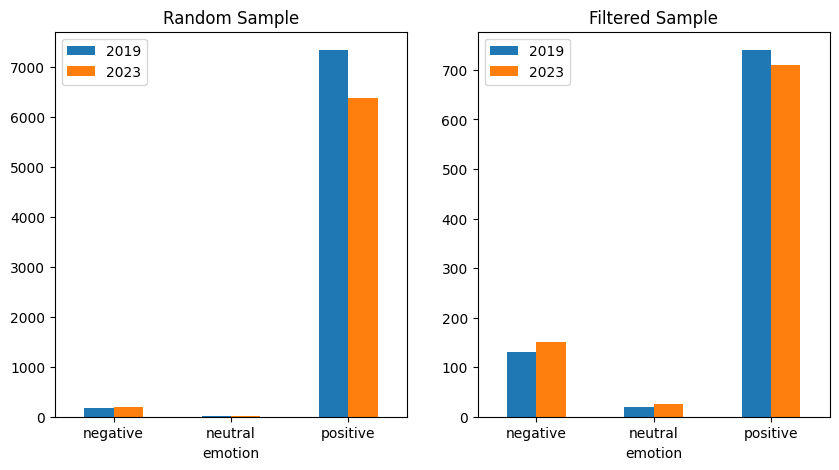

In [ ]:
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))


###### First example ########

###### Random sample ########
random19 = check19
random23 = check23

random19 = random19[['listing_id', 'year', 'emotion']]
random19 = random19.groupby('emotion')['emotion'].count()
random19 = pd.DataFrame(random19)
random19.rename(columns={'emotion' : '2019'}, inplace=True)

random23 = random23[['listing_id', 'year', 'emotion']]
random23 = random23.groupby('emotion')['emotion'].count()
random23 = pd.DataFrame(random23)
random23.rename(columns={'emotion' : '2023'}, inplace=True)

random = pd.merge(random19, random23, left_index = True, right_index = True)
random.plot(kind='bar', ax=ax1 ,figsize=(10,5), rot=0)
ax1.set_title('Random Sample')

###### Filtered sample ########
filt19 = filtered19
filt23 = filtered23

filt19 = filt19[['listing_id', 'year', 'emotion']]
filt19 = filt19.groupby('emotion')['emotion'].count()
filt19 = pd.DataFrame(filt19)
filt19.rename(columns={'emotion' : '2019'}, inplace=True)

filt23 = filt23[['listing_id', 'year', 'emotion']]
filt23 = filt23.groupby('emotion')['emotion'].count()
filt23 = pd.DataFrame(filt23)
filt23.rename(columns={'emotion' : '2023'}, inplace=True)

filtered = pd.merge(filt19, filt23, left_index = True, right_index = True)
filtered.plot(kind='bar', ax=ax2, figsize=(10,5), rot=0)
ax2.set_title('Filtered Sample')

plt.show()

## Question 2: Sentiment analysis

### Set preparation

Splitting the dataset into training and testing sets.

In [ ]:
from sklearn.model_selection import train_test_split

filt19 = filtered19
filt19 = filt19[['comments', 'emotion']]

filt23 = filtered23
filt23 = filt23[['comments', 'emotion']]

data = pd.concat([filt19, filt23])

# Split the data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Save as tsv
train_data.to_csv('train_data.tsv', sep='\t', index=False)
test_data.to_csv('test_data.tsv', sep='\t', index=False)

,comments,emotion
4989,olgas flat spacious located good area quiet ac...,negative
1945,superhost one best airbnb experiences ever geo...,positive
488,first impression apartment looked lived hand p...,negative
5494,best ever department ive seen airbnb place goo...,positive
1886,liked aleqsandras placeit amazingclose centeri...,positive
...,...,...
1643,great location terrace amazing,positive
2627,antonis helped us throughout stay always respo...,positive
588,loved olgas place location great appartement c...,positive
3825,nice good,neutral


Creating features using TF-IDF and Word Embeddings (pre-trained).

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np
import pickle

# Load the training and testing data
train_data = pd.read_csv('train_data.tsv', sep='\t')
test_data = pd.read_csv('test_data.tsv', sep='\t')

# Get the comments
train_texts = train_data['comments'].fillna('')
test_texts = test_data['comments'].fillna('')


### TF-IDF Feature ###

# Do tfidf and then transform so we have the words present
tfidf_vectorizer = TfidfVectorizer()
tfidf_train = tfidf_vectorizer.fit_transform(train_texts)
tfidf_test = tfidf_vectorizer.transform(test_texts)

# Convert to DataFrames
tfidf_train_df = pd.DataFrame(tfidf_train.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Save .pkl files
with open('tfidf_train.pkl', 'wb') as f:
    pickle.dump(tfidf_train_df, f)

with open('tfidf_test.pkl', 'wb') as f:
    pickle.dump(tfidf_test_df, f)

### Word2Vec Feature ###

# Tokenization
def tokenize(text):
    return text.split()

train_tokens = train_texts.apply(tokenize)
test_tokens = test_texts.apply(tokenize)

# Word2Vec model
model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=2, workers=4)
model.save("word2vec.model")

# Function to calculate the comment placement, based on its words
def document_vector(tokens, model):
    # Remove out-of-vocabulary words
    tokens = [token for token in tokens if token in model.wv]
    if not tokens:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[tokens], axis=0)

# Get comments vectors
train_vectors = np.array([document_vector(tokens, model) for tokens in train_tokens])
test_vectors = np.array([document_vector(tokens, model) for tokens in test_tokens])

# Convert to DataFrames
train_vectors_df = pd.DataFrame(train_vectors)
test_vectors_df = pd.DataFrame(test_vectors)

# Save .pkl files
with open('word2vec_train.pkl', 'wb') as f:
    pickle.dump(train_vectors_df, f)

with open('word2vec_test.pkl', 'wb') as f:
    pickle.dump(test_vectors_df, f)


Number of NaN values in each column:
comments    2
emotion     0
dtype: int64
TF-IDF features have been extracted and saved as tfidf_train.pkl and tfidf_test.pkl
Word embeddings have been extracted and saved as word2vec_train.pkl and word2vec_test.pkl


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.129382,0.306684,0.031914,0.034495,0.058909,-0.447778,0.183245,0.593620,-0.305823,-0.228579,...,0.354789,0.065487,0.009165,0.182757,0.421792,0.353122,0.121991,-0.408894,0.071173,0.040202
1,-0.150730,0.356151,0.040675,0.037853,0.068111,-0.518880,0.208279,0.687125,-0.351443,-0.265833,...,0.410573,0.076315,0.010465,0.208965,0.490592,0.410277,0.137613,-0.471524,0.082799,0.046326
2,-0.113380,0.271952,0.029141,0.030750,0.053159,-0.397195,0.162603,0.526898,-0.269938,-0.202144,...,0.313612,0.057580,0.007521,0.163974,0.374563,0.314056,0.105260,-0.362199,0.062531,0.035915
3,-0.144417,0.342589,0.036992,0.036425,0.067001,-0.497641,0.200643,0.660896,-0.341546,-0.256378,...,0.395200,0.075592,0.012221,0.200785,0.470915,0.393976,0.132250,-0.451929,0.079762,0.044210
4,-0.137963,0.313342,0.036385,0.039420,0.056641,-0.456878,0.187575,0.603096,-0.310393,-0.233997,...,0.360412,0.074785,0.006785,0.181135,0.435559,0.369128,0.122635,-0.408487,0.072029,0.043423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1415,-0.187870,0.455163,0.054067,0.050706,0.089532,-0.658260,0.268146,0.879349,-0.450935,-0.334071,...,0.528223,0.094059,0.013794,0.266682,0.621654,0.519299,0.184331,-0.595840,0.099437,0.059558
1416,-0.160563,0.387749,0.042405,0.042229,0.075841,-0.566129,0.229251,0.750345,-0.384455,-0.289153,...,0.448263,0.082797,0.010671,0.231449,0.533522,0.447982,0.153389,-0.512718,0.089094,0.050522
1417,-0.144001,0.339088,0.040160,0.037076,0.066227,-0.496491,0.201111,0.661056,-0.337159,-0.253897,...,0.392637,0.074420,0.010437,0.199574,0.469708,0.389950,0.138382,-0.448346,0.079672,0.044375
1418,-0.195007,0.458819,0.041230,0.052685,0.084461,-0.675857,0.265539,0.885635,-0.458574,-0.345143,...,0.529813,0.108159,0.017632,0.279291,0.631256,0.519462,0.180841,-0.604386,0.105036,0.066685


### SVM

In [ ]:
import pandas as pd
import pickle
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict

# Load the labels
train_data = pd.read_csv('train_data.tsv', sep='\t')
test_data = pd.read_csv('test_data.tsv', sep='\t')

train_labels = train_data['emotion']
test_labels = test_data['emotion']

# Load the TF-IDF features
with open('tfidf_train.pkl', 'rb') as f:
    tfidf_train_df = pickle.load(f)

with open('tfidf_test.pkl', 'rb') as f:
    tfidf_test_df = pickle.load(f)

# Scale the features
scaler = StandardScaler()
tfidf_train_scaled = scaler.fit_transform(tfidf_train_df)
tfidf_test_scaled = scaler.transform(tfidf_test_df)

# 10-fold cross-validation for TF-IDF
svm_tfidf = SVC(kernel='linear')
cv_scores_tfidf = cross_val_score(svm_tfidf, tfidf_train_scaled, train_labels, cv=10)
cv_predictions_tfidf = cross_val_predict(svm_tfidf, tfidf_train_scaled, train_labels, cv=10)

# Print the report card
print("TF-IDF SVM Cross-Validation Results")
print("Cross-Validation Accuracy Scores:", cv_scores_tfidf)
print("Mean Cross-Validation Accuracy:", np.mean(cv_scores_tfidf))
print("Classification Report (Training):")
print(classification_report(train_labels, cv_predictions_tfidf))

# Load the Word2Vec features
with open('word2vec_train.pkl', 'rb') as f:
    word2vec_train_df = pickle.load(f)

with open('word2vec_test.pkl', 'rb') as f:
    word2vec_test_df = pickle.load(f)

# Scale the features
word2vec_train_scaled = scaler.fit_transform(word2vec_train_df)
word2vec_test_scaled = scaler.transform(word2vec_test_df)

# 10-fold cross-validation for Word2Vec
svm_word2vec = SVC(kernel='linear')
cv_scores_word2vec = cross_val_score(svm_word2vec, word2vec_train_scaled, train_labels, cv=10)
cv_predictions_word2vec = cross_val_predict(svm_word2vec, word2vec_train_scaled, train_labels, cv=10)

# Print the report card
print("Word2Vec SVM Cross-Validation Results")
print("Cross-Validation Accuracy Scores:", cv_scores_word2vec)
print("Mean Cross-Validation Accuracy:", np.mean(cv_scores_word2vec))
print("Classification Report (Training):")
print(classification_report(train_labels, cv_predictions_word2vec))

# Do the actual evaluation on the testing set
svm_tfidf.fit(tfidf_train_scaled, train_labels)
tfidf_test_predictions = svm_tfidf.predict(tfidf_test_scaled)

svm_word2vec.fit(word2vec_train_scaled, train_labels)
word2vec_test_predictions = svm_word2vec.predict(word2vec_test_scaled)

# Print results #

print("TF-IDF SVM Test Set Results")
print("Accuracy:", accuracy_score(test_labels, tfidf_test_predictions))
print("Classification Report (Testing):")
print(classification_report(test_labels, tfidf_test_predictions))

print("Word2Vec SVM Test Set Results")
print("Accuracy:", accuracy_score(test_labels, word2vec_test_predictions))
print("Classification Report (Testing):")
print(classification_report(test_labels, word2vec_test_predictions))


TF-IDF SVM Cross-Validation Results
Cross-Validation Accuracy Scores: [0.83802817 0.82394366 0.83098592 0.81690141 0.81690141 0.85211268
 0.84507042 0.84507042 0.86619718 0.84507042]
Mean Cross-Validation Accuracy: 0.8380281690140846
Classification Report (Training):
              precision    recall  f1-score   support

    negative       0.81      0.33      0.47       236
     neutral       0.17      0.10      0.12        40
    positive       0.85      0.97      0.91      1144

    accuracy                           0.84      1420
   macro avg       0.61      0.47      0.50      1420
weighted avg       0.83      0.84      0.81      1420

Word2Vec SVM Cross-Validation Results
Cross-Validation Accuracy Scores: [0.88028169 0.87323944 0.84507042 0.88028169 0.85211268 0.86619718
 0.85211268 0.85211268 0.86619718 0.88732394]
Mean Cross-Validation Accuracy: 0.8654929577464789
Classification Report (Training):
              precision    recall  f1-score   support

    negative       0.73   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TF-IDF SVM Test Set Results
Accuracy: 0.895774647887324
Classification Report (Testing):
              precision    recall  f1-score   support

    negative       0.77      0.56      0.65        43
     neutral       0.43      0.30      0.35        10
    positive       0.92      0.96      0.94       302

    accuracy                           0.90       355
   macro avg       0.71      0.61      0.65       355
weighted avg       0.89      0.90      0.89       355

Word2Vec SVM Test Set Results
Accuracy: 0.8760563380281691
Classification Report (Testing):
              precision    recall  f1-score   support

    negative       0.63      0.51      0.56        43
     neutral       0.00      0.00      0.00        10
    positive       0.90      0.96      0.93       302

    accuracy                           0.88       355
   macro avg       0.51      0.49      0.50       355
weighted avg       0.84      0.88      0.86       355



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random Forests

In [ ]:
import pandas as pd
import pickle
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict

# Load the labels
train_data = pd.read_csv('train_data.tsv', sep='\t')
test_data = pd.read_csv('test_data.tsv', sep='\t')

train_labels = train_data['emotion']
test_labels = test_data['emotion']

# Load the TF-IDF features
with open('tfidf_train.pkl', 'rb') as f:
    tfidf_train_df = pickle.load(f)

with open('tfidf_test.pkl', 'rb') as f:
    tfidf_test_df = pickle.load(f)

# Scale the features
scaler = StandardScaler()
tfidf_train_scaled = scaler.fit_transform(tfidf_train_df)
tfidf_test_scaled = scaler.transform(tfidf_test_df)

# 10-fold cross-validation for TF-IDF
rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores_tfidf = cross_val_score(rf_tfidf, tfidf_train_scaled, train_labels, cv=10)
cv_predictions_tfidf = cross_val_predict(rf_tfidf, tfidf_train_scaled, train_labels, cv=10)

print("TF-IDF Random Forest Cross-Validation Results")
print("Cross-Validation Accuracy Scores:", cv_scores_tfidf)
print("Mean Cross-Validation Accuracy:", np.mean(cv_scores_tfidf))
print("Classification Report (Training):")
print(classification_report(train_labels, cv_predictions_tfidf))

# Load the Word2Vec features
with open('word2vec_train.pkl', 'rb') as f:
    word2vec_train_df = pickle.load(f)

with open('word2vec_test.pkl', 'rb') as f:
    word2vec_test_df = pickle.load(f)

# Scale the features
word2vec_train_scaled = scaler.fit_transform(word2vec_train_df)
word2vec_test_scaled = scaler.transform(word2vec_test_df)

# 10-fold cross-validation for Word2Vec
rf_word2vec = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores_word2vec = cross_val_score(rf_word2vec, word2vec_train_scaled, train_labels, cv=10)
cv_predictions_word2vec = cross_val_predict(rf_word2vec, word2vec_train_scaled, train_labels, cv=10)

print("Word2Vec Random Forest Cross-Validation Results")
print("Cross-Validation Accuracy Scores:", cv_scores_word2vec)
print("Mean Cross-Validation Accuracy:", np.mean(cv_scores_word2vec))
print("Classification Report (Training):")
print(classification_report(train_labels, cv_predictions_word2vec))

# Do the actual evaluation on the testing set
rf_tfidf.fit(tfidf_train_scaled, train_labels)
tfidf_test_predictions = rf_tfidf.predict(tfidf_test_scaled)

rf_word2vec.fit(word2vec_train_scaled, train_labels)
word2vec_test_predictions = rf_word2vec.predict(word2vec_test_scaled)

# Print results #

print("TF-IDF Random Forest Test Set Results")
print("Accuracy:", accuracy_score(test_labels, tfidf_test_predictions))
print("Classification Report (Testing):")
print(classification_report(test_labels, tfidf_test_predictions))

print("Word2Vec Random Forest Test Set Results")
print("Accuracy:", accuracy_score(test_labels, word2vec_test_predictions))
print("Classification Report (Testing):")
print(classification_report(test_labels, word2vec_test_predictions))

TF-IDF Random Forest Cross-Validation Results
Cross-Validation Accuracy Scores: [0.85211268 0.86619718 0.82394366 0.85915493 0.83098592 0.87323944
 0.83802817 0.85915493 0.87323944 0.85211268]
Mean Cross-Validation Accuracy: 0.8528169014084506
Classification Report (Training):
              precision    recall  f1-score   support

    negative       0.90      0.32      0.47       236
     neutral       0.33      0.03      0.05        40
    positive       0.85      0.99      0.92      1144

    accuracy                           0.85      1420
   macro avg       0.70      0.44      0.48      1420
weighted avg       0.85      0.85      0.82      1420

Word2Vec Random Forest Cross-Validation Results
Cross-Validation Accuracy Scores: [0.86619718 0.85915493 0.8028169  0.88028169 0.78169014 0.86619718
 0.81690141 0.84507042 0.85915493 0.84507042]
Mean Cross-Validation Accuracy: 0.8422535211267606
Classification Report (Training):
              precision    recall  f1-score   support

    ne

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### KNN

In [ ]:
import pandas as pd
import pickle
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict

# Load the labels
train_data = pd.read_csv('train_data.tsv', sep='\t')
test_data = pd.read_csv('test_data.tsv', sep='\t')

train_labels = train_data['emotion']
test_labels = test_data['emotion']

# Load the TF-IDF features
with open('tfidf_train.pkl', 'rb') as f:
    tfidf_train_df = pickle.load(f)

with open('tfidf_test.pkl', 'rb') as f:
    tfidf_test_df = pickle.load(f)

# Scale the features
scaler = StandardScaler()
tfidf_train_scaled = scaler.fit_transform(tfidf_train_df)
tfidf_test_scaled = scaler.transform(tfidf_test_df)

# 10-fold cross-validation for TF-IDF
knn_tfidf = KNeighborsClassifier(n_neighbors=5)
cv_scores_tfidf = cross_val_score(knn_tfidf, tfidf_train_scaled, train_labels, cv=10)
cv_predictions_tfidf = cross_val_predict(knn_tfidf, tfidf_train_scaled, train_labels, cv=10)

# Print the report card
print("TF-IDF KNN Cross-Validation Results")
print("Cross-Validation Accuracy Scores:", cv_scores_tfidf)
print("Mean Cross-Validation Accuracy:", np.mean(cv_scores_tfidf))
print("Classification Report:")
print(classification_report(train_labels, cv_predictions_tfidf))

# Load the Word2Vec features
with open('word2vec_train.pkl', 'rb') as f:
    word2vec_train_df = pickle.load(f)

with open('word2vec_test.pkl', 'rb') as f:
    word2vec_test_df = pickle.load(f)

# Scale the features
word2vec_train_scaled = scaler.fit_transform(word2vec_train_df)
word2vec_test_scaled = scaler.transform(word2vec_test_df)

# Train and evaluate the KNN model on Word2Vec features using 10-fold cross-validation
knn_word2vec = KNeighborsClassifier(n_neighbors=5)
cv_scores_word2vec = cross_val_score(knn_word2vec, word2vec_train_scaled, train_labels, cv=10)
cv_predictions_word2vec = cross_val_predict(knn_word2vec, word2vec_train_scaled, train_labels, cv=10)

# Print the report card
print("Word2Vec KNN Cross-Validation Results")
print("Cross-Validation Accuracy Scores:", cv_scores_word2vec)
print("Mean Cross-Validation Accuracy:", np.mean(cv_scores_word2vec))
print("Classification Report:")
print(classification_report(train_labels, cv_predictions_word2vec))

# Do the actual evaluation on the testing set
knn_tfidf.fit(tfidf_train_scaled, train_labels)
tfidf_test_predictions = knn_tfidf.predict(tfidf_test_scaled)

knn_word2vec.fit(word2vec_train_scaled, train_labels)
word2vec_test_predictions = knn_word2vec.predict(word2vec_test_scaled)

# Print results #

print("TF-IDF KNN Test Set Results")
print("Accuracy:", accuracy_score(test_labels, tfidf_test_predictions))
print(classification_report(test_labels, tfidf_test_predictions))

print("Word2Vec KNN Test Set Results")
print("Accuracy:", accuracy_score(test_labels, word2vec_test_predictions))
print(classification_report(test_labels, word2vec_test_predictions))


TF-IDF KNN Cross-Validation Results
Cross-Validation Accuracy Scores: [0.72535211 0.75352113 0.75352113 0.55633803 0.53521127 0.76056338
 0.73239437 0.70422535 0.74647887 0.77464789]
Mean Cross-Validation Accuracy: 0.7042253521126761
Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.09      0.17       236
     neutral       0.04      0.20      0.06        40
    positive       0.82      0.85      0.83      1144

    accuracy                           0.70      1420
   macro avg       0.62      0.38      0.36      1420
weighted avg       0.83      0.70      0.70      1420

Word2Vec KNN Cross-Validation Results
Cross-Validation Accuracy Scores: [0.80985915 0.81690141 0.75352113 0.78873239 0.76056338 0.85211268
 0.79577465 0.82394366 0.83802817 0.79577465]
Mean Cross-Validation Accuracy: 0.8035211267605634
Classification Report:
              precision    recall  f1-score   support

    negative       0.49      0.42      0.45     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Question 3: Similarity (Jaccard, Cosine, etc.) and Semantic Neighborhoods

Calculation and storage of cosine similarity

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import numpy as np
from numpy import dot
from numpy.linalg import norm
from scipy.stats import pearsonr
import pickle

data19 = pd.read_csv('/content/gdrive/MyDrive/data/sample_withemotion_19.csv')
data23 = pd.read_csv('/content/gdrive/MyDrive/data/sample_withemotion_23.csv')

data = pd.concat([data19, data23])
data = data[data['comments'].notnull()]

# Tokenize comments
tokenized_comments = data['comments'].apply(lambda x: x.split())

# Train Word2Vec model
model = Word2Vec(sentences=tokenized_comments, vector_size=100, window=5, min_count=1, workers=4)

# Get all word vectors in the vocabulary
vocab = list(model.wv.index_to_key)
vectors = np.array([model.wv[word] for word in vocab])

# Normalize word vectors
norm_vectors = vectors / np.linalg.norm(vectors, axis=1)[:, np.newaxis]

# Compute similarity matrix
similarity_matrix = np.dot(norm_vectors, norm_vectors.T)

# Create a mapping from word to index
word_to_index = {word: i for i, word in enumerate(vocab)}

similarity_df = pd.DataFrame(similarity_matrix, columns=word_to_index.keys(), index=word_to_index.keys())

# Save .pkl file
with open('similarity_matrix.pkl', 'wb') as file:
    pickle.dump(similarity_df, file)


display(similarity_df)

,great,apartment,place,stay,location,athens,clean,host,nice,us,...,semester,companies,activites,servethe,playingsinging,musical,musician,fi,nibble,informationsupport
great,1.000000,0.403220,0.405038,0.276046,0.449512,0.442581,0.587322,0.363942,0.798917,0.310579,...,0.383178,0.303024,0.205492,0.292724,0.338423,0.417691,0.404466,0.334392,0.278146,0.319725
apartment,0.403220,1.000000,0.851310,0.368941,0.654509,0.462750,0.651510,0.373442,0.400875,0.082974,...,0.470130,0.495879,0.281605,0.375903,0.211650,0.587444,0.540397,0.475162,0.244960,0.470419
place,0.405038,0.851310,1.000000,0.643515,0.664584,0.661615,0.503845,0.457389,0.268175,0.072615,...,0.588355,0.444941,0.194102,0.351483,0.236836,0.577958,0.544842,0.425216,0.204415,0.520813
stay,0.276046,0.368941,0.643515,1.000000,0.449983,0.494207,0.355562,0.521397,0.156977,0.222165,...,0.652551,0.336295,0.190678,0.251959,0.241518,0.463714,0.488889,0.373614,0.298643,0.463196
location,0.449512,0.654509,0.664584,0.449983,1.000000,0.595363,0.666737,0.498869,0.382129,0.065802,...,0.359796,0.378116,0.203489,0.313988,0.175509,0.524240,0.429982,0.307749,0.071165,0.392743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
musical,0.417691,0.587444,0.577958,0.463714,0.524240,0.452639,0.496644,0.343266,0.517101,0.292318,...,0.729523,0.425254,0.448525,0.534610,0.578807,1.000000,0.831412,0.718247,0.662378,0.580762
musician,0.404466,0.540397,0.544842,0.488889,0.429982,0.448746,0.400503,0.375073,0.454569,0.412616,...,0.772935,0.323525,0.527595,0.547299,0.675947,0.831412,1.000000,0.722528,0.737430,0.706006
fi,0.334392,0.475162,0.425216,0.373614,0.307749,0.185601,0.536573,0.410132,0.496755,0.378159,...,0.711634,0.533801,0.502670,0.571260,0.532935,0.718247,0.722528,1.000000,0.747149,0.662189
nibble,0.278146,0.244960,0.204415,0.298643,0.071165,0.125537,0.225533,0.270194,0.395483,0.551627,...,0.676184,0.269355,0.599203,0.484379,0.704858,0.662378,0.737430,0.747149,1.000000,0.637105


Process for computing the required results for words X, Y, and a constant N.

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import numpy as np
from numpy import dot
from numpy.linalg import norm
from scipy.stats import pearsonr
import pickle

# Load .pkl file
with open('similarity_matrix.pkl', 'rb') as file:
    similarity_df = pickle.load(file)

# Finds the similarity between two given words #
def get_similarity_from_matrix(word1, word2, similarity_df):
    if word1 in similarity_df.index and word2 in similarity_df.columns:
      return similarity_df.loc[word1, word2]
    else:
      return None # If one of the two words doesn't exist return None

# Finds the N closest words to the word given #
def get_neighborhood(word, N, similarity_df):
    if word not in similarity_df.index:
      return None  # Or handle the case where the word is not in the vocabulary

    # Get similarity scores for the word
    similarity_scores = similarity_df.loc[word]
    # Get indices of the top N similar words (excluding the word itself)
    top_n_indices = similarity_scores.argsort()[-N-1:-1][::-1]
    # Map indices back to words and similarity scores
    neighborhood = [(vocab[i], similarity_scores[i]) for i in top_n_indices]
    return neighborhood

# Function implementing (a) maximum similarity of neighborhoods #
def max_similarity_of_neighborhoods(word1, word2, N, similarity_df):
    # Get the neighborhoods
    neighborhood1 = get_neighborhood(word1, N, similarity_df)
    neighborhood2 = get_neighborhood(word2, N, similarity_df)

    # Check for non-existance
    if not neighborhood1 or not neighborhood2:
        return None

    # Find the pair from the 2 neighborhoods with max similarity
    max_sim = -10
    for w1, _ in neighborhood1:
        for w2, _ in neighborhood2:
            similarity = get_similarity_from_matrix(w1, w2, similarity_df)
            if similarity is not None and similarity > max_sim:
                max_sim = similarity

    return max_sim

# Function implementing (b) correlation of neighborhood similarities #
def correlation_of_neighborhood_similarities(word1, word2, N, similarity_df):
    # Get the neighborhoods
    neighborhood1 = get_neighborhood(word1, N, similarity_df)
    neighborhood2 = get_neighborhood(word2, N, similarity_df)

    if not neighborhood1 or not neighborhood2:
        return None

    # Calculating the similarity vectors (third line of the given equation) #

    # word1 with every word in his neighborhood
    similarities1_with_word1 = np.array([sim for _, sim in neighborhood1])
    # word2 with every word in word1's neighborhood
    similarities1_with_word2 = np.array([get_similarity_from_matrix(word2, w, similarity_df) for w, _ in neighborhood1])

    # word2 with every word in his neighborhood
    similarities2_with_word2 = np.array([sim for _, sim in neighborhood2])
    # word1 with every word in word2's neighborhood
    similarities2_with_word1 = np.array([get_similarity_from_matrix(word1, w, similarity_df) for w, _ in neighborhood2])

    # Ensure lengths match
    if len(similarities1_with_word1) != len(similarities1_with_word2) or len(similarities2_with_word2) != len(similarities2_with_word1):
        return None

    # Compute correlations (second line of the given equation) #
    b_ij, _ = pearsonr(similarities1_with_word1, similarities1_with_word2)
    b_ji, _ = pearsonr(similarities2_with_word1, similarities2_with_word2)

    # Return max correlation (first line of the given equation) #
    return max(b_ij, b_ji)

# Function implementing (c) sum of squared neighborhood similarities #
def sum_of_squared_neighborhood_similarities(word1, word2, N, similarity_df):
    # Get the neighborhoods
    neighborhood1 = get_neighborhood(word1, N, similarity_df)
    neighborhood2 = get_neighborhood(word2, N, similarity_df)

    if not neighborhood1 or not neighborhood2:
        return None

    # word1's neighbors with word2
    similarities1 = np.array([get_similarity_from_matrix(word2, w, similarity_df) for w, _ in neighborhood1])

    # word2's neighbors with word1
    similarities2 = np.array([get_similarity_from_matrix(word1, w, similarity_df) for w, _ in neighborhood2])

    # Sum of squared similarities
    sum_squared_similarities = np.sum(similarities1 ** 2) + np.sum(similarities2 ** 2)

    return np.sqrt(sum_squared_similarities)

def calculate_stats(word1, word2, N):
  similarity = get_similarity_from_matrix(word1, word2, similarity_df)
  print(f"Cosine similarity between '{word1}' and '{word2}': {similarity}")

  neighborhood = get_neighborhood(word1, N, similarity_df)
  print(f"Neighborhood of '{word1}' ({N} instances): {neighborhood}")

  neighborhood = get_neighborhood(word2, N, similarity_df)
  print(f"Neighborhood of '{word2}' ({N} instances): {neighborhood}")

  similarity = max_similarity_of_neighborhoods(word1, word2, N, similarity_df)
  print(f"Max similarity of neighborhoods of words '{word1}' and '{word2}': {similarity}")

  similarity = correlation_of_neighborhood_similarities(word1, word2, N, similarity_df)
  print(f"Correlation of neighborhood similarities '{word1}' and '{word2}': {similarity}")

  similarity = sum_of_squared_neighborhood_similarities(word1, word2, N, similarity_df)
  print(f"Sum of squared neighborhood similarities '{word1}' and '{word2}': {similarity}")

### Example usage ###
calculate_stats('coffee', 'wifi', 5)


Cosine similarity between 'coffee' and 'wifi': 0.6079972982406616
Neighborhood of 'coffee' (5 instances): [('breakfast', 0.9207219), ('etc', 0.9177468), ('cup', 0.8737552), ('tea', 0.8735779), ('pastry', 0.8708859)]
Neighborhood of 'wifi' (5 instances): [('washer', 0.96879745), ('towels', 0.9583194), ('smart', 0.9562217), ('sheets', 0.94595605), ('pillows', 0.9459142)]
Max similarity of neighborhoods of words 'coffee' and 'wifi': 0.9141324162483215
Correlation of neighborhood similarities 'coffee' and 'wifi': 0.7711053597306483
Sum of squared neighborhood similarities 'coffee' and 'wifi': 2.0735323429107666


Visualization of word neighborhoods.

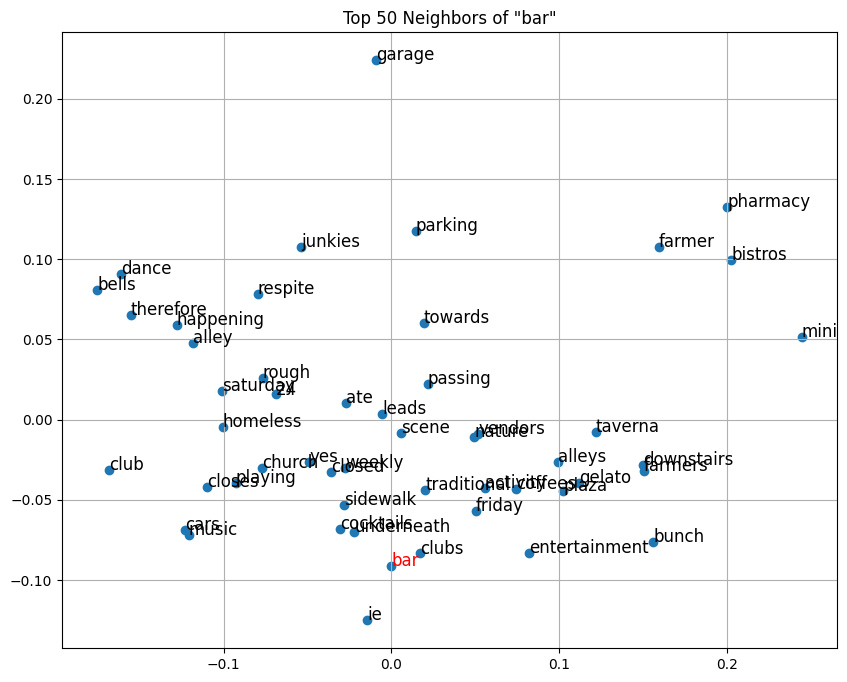

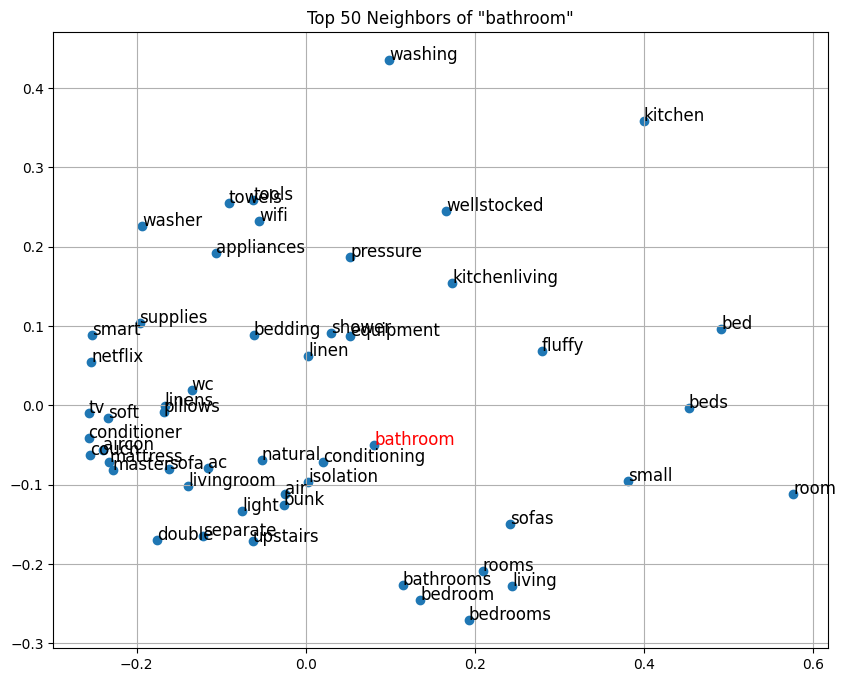

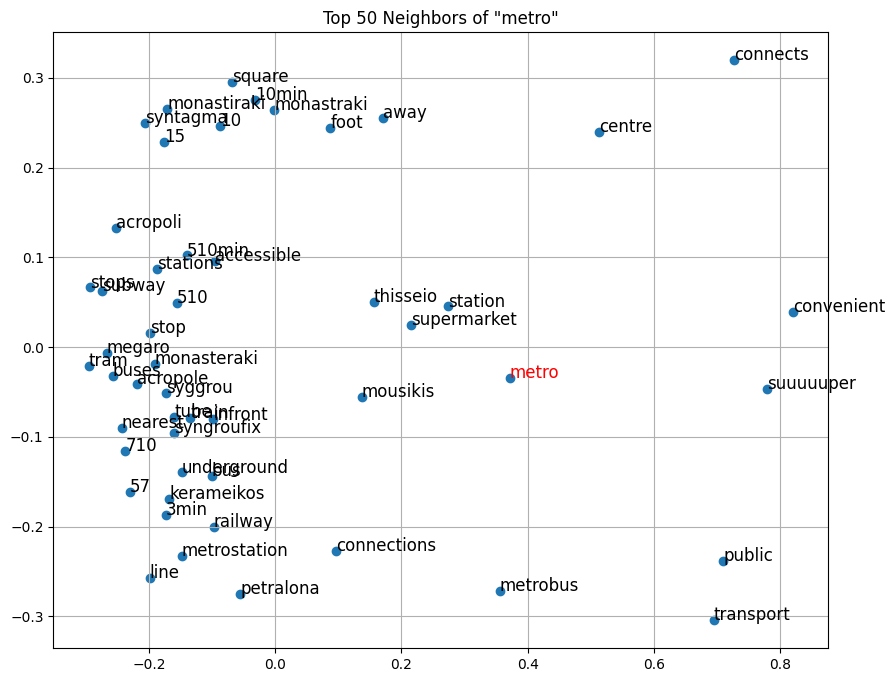

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load .pkl file
with open('similarity_matrix.pkl', 'rb') as file:
    similarity_df = pickle.load(file)

# Set value for N
N = 50

def plot_neighborhood(word, N):
    top_n_neighbors = get_neighborhood(word, N, similarity_df)

    # Extract only the words from the top_n_neighbors
    neighbor_words = [neighbor[0] for neighbor in top_n_neighbors]
    neighbor_words.append(word)
    subset_df = similarity_df.loc[neighbor_words, neighbor_words]

    # Reduce dimensionality to 2D
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(subset_df)

    # DataFrame with the PCA results
    pca_df = pd.DataFrame(pca_result, index=subset_df.index, columns=['PC1', 'PC2'])

    # Plot the results
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_df['PC1'], pca_df['PC2'])

    # We want the 'word' to be red, in order to be distinguished from its neighbors
    for w, (x, y) in pca_df.iterrows():
        plt.text(x, y, w, fontsize=12, color='red' if w == word else 'black')

    plt.title(f'Top {N} Neighbors of "{word}"')
    plt.grid(True)
    plt.show()

# Some example words
plot_neighborhood('bar', N)
plot_neighborhood('bathroom', N)
plot_neighborhood('metro', N)
